# About This notebook

## Version 0

- Five KFolds splits
- No Feature Engineering
- Remove unecessary variables

## Version 1

- 25 KFolds splits
- No Feature Engineering
- Remove unecessary variables

In [1]:
! pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 361.3 kB/s eta 0:00:00


# Library

In [2]:
import os
import random
import time
import pickle
import psutil
import gc
from tqdm.auto import tqdm


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

from math import sqrt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2


import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric

# setting some globl config

plt.style.use('ggplot')
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams["figure.facecolor"] = '#FFFACD'
plt.rcParams["axes.facecolor"] = '#FFFFE0'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = orange_black[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'


import warnings
warnings.filterwarnings("ignore")

INFERENCE = True
VERSION=1

# Data Loading

In [3]:
train = pd.read_csv('../input/veolia-competition/input_train_wide_format.csv')
target = pd.read_csv('../input/veolia-competition/output_train_wide_format.csv') 
test  = pd.read_csv('../input/veolia-competition/input_test_wide_format_b10i0rq.csv')
submission = pd.read_csv('../input/veolia-competition/output_test_rand.csv')

# Merge train data with target
train = train.join(target.set_index('ID'), on='ID')
target_cols = [col for col in target.columns if 'SO2_MAS' in col]

del target
_ = gc.collect()

In [4]:
train.head()

,ID,weekday-48,weekday-47,weekday-46,weekday-45,weekday-44,weekday-43,weekday-42,weekday-41,weekday-40,...,SO2_MAS+2,SO2_MAS+3,SO2_MAS+4,SO2_MAS+5,SO2_MAS+6,SO2_MAS+7,SO2_MAS+8,SO2_MAS+9,SO2_MAS+10,SO2_MAS+11
0,0,7,7,7,7,7,7,7,7,7,...,2,2,3,3,4,3,2,2,1,2
1,1,7,7,7,7,7,7,7,7,7,...,2,3,3,4,3,2,2,1,2,2
2,2,7,7,7,7,7,7,7,7,7,...,3,3,4,3,2,2,1,2,2,1
3,3,7,7,7,7,7,7,7,7,7,...,3,4,3,2,2,1,2,2,1,1
4,4,7,7,7,7,7,7,7,7,7,...,4,3,2,2,1,2,2,1,1,1


In [5]:
train = train.dropna()
train.isnull().sum().sort_values()

ID                        0
cloudCoveragePercent-1    0
cloudCoveragePercent-2    0
cloudCoveragePercent-3    0
cloudCoveragePercent-4    0
                         ..
x_wgs84_HAR-37            0
x_wgs84_HAR-38            0
x_wgs84_HAR-39            0
x_wgs84_HAR-9             0
SO2_MAS+11                0
Length: 2077, dtype: int64

# Remove unecessary columns

### Remove X Y coordinates

In [6]:
# X coordinate
x_wgs84_GOR_col = [col for col in train.columns if 'x_wgs84_GOR' in col]
x_wgs84_HAR_col = [col for col in train.columns if 'x_wgs84_HAR' in col]
x_wgs84_CAU_col = [col for col in train.columns if 'x_wgs84_CAU' in col]
x_wgs84_STA_col = [col for col in train.columns if 'x_wgs84_STA' in col]
x_wgs84_MAS_col = [col for col in train.columns if 'x_wgs84_MAS' in col]
x_wgs84_HRI_col = [col for col in train.columns if 'x_wgs84_HRI' in col]
x_wgs84_HVH_col = [col for col in train.columns if 'x_wgs84_HVH' in col]

# Y coordinate
y_wgs84_GOR_col = [col for col in train.columns if 'y_wgs84_GOR' in col]
y_wgs84_HAR_col = [col for col in train.columns if 'y_wgs84_HAR' in col]
y_wgs84_CAU_col = [col for col in train.columns if 'y_wgs84_CAU' in col]
y_wgs84_STA_col = [col for col in train.columns if 'y_wgs84_STA' in col]
y_wgs84_MAS_col = [col for col in train.columns if 'y_wgs84_MAS' in col]
y_wgs84_HRI_col = [col for col in train.columns if 'y_wgs84_HRI' in col]
y_wgs84_HVH_col = [col for col in train.columns if 'y_wgs84_HVH' in col]

#### Mode of every variable in train test data

In [7]:
train[x_wgs84_GOR_col].mode()

,x_wgs84_GOR-48,x_wgs84_GOR-47,x_wgs84_GOR-46,x_wgs84_GOR-45,x_wgs84_GOR-44,x_wgs84_GOR-43,x_wgs84_GOR-42,x_wgs84_GOR-41,x_wgs84_GOR-40,x_wgs84_GOR-39,...,x_wgs84_GOR-10,x_wgs84_GOR-9,x_wgs84_GOR-8,x_wgs84_GOR-7,x_wgs84_GOR-6,x_wgs84_GOR-5,x_wgs84_GOR-4,x_wgs84_GOR-3,x_wgs84_GOR-2,x_wgs84_GOR-1
0,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,...,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486


In [8]:
test[x_wgs84_GOR_col].mode()

,x_wgs84_GOR-48,x_wgs84_GOR-47,x_wgs84_GOR-46,x_wgs84_GOR-45,x_wgs84_GOR-44,x_wgs84_GOR-43,x_wgs84_GOR-42,x_wgs84_GOR-41,x_wgs84_GOR-40,x_wgs84_GOR-39,...,x_wgs84_GOR-10,x_wgs84_GOR-9,x_wgs84_GOR-8,x_wgs84_GOR-7,x_wgs84_GOR-6,x_wgs84_GOR-5,x_wgs84_GOR-4,x_wgs84_GOR-3,x_wgs84_GOR-2,x_wgs84_GOR-1
0,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,...,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486,0.232486


In [9]:
train[x_wgs84_HAR_col].mode()

,x_wgs84_HAR-48,x_wgs84_HAR-47,x_wgs84_HAR-46,x_wgs84_HAR-45,x_wgs84_HAR-44,x_wgs84_HAR-43,x_wgs84_HAR-42,x_wgs84_HAR-41,x_wgs84_HAR-40,x_wgs84_HAR-39,...,x_wgs84_HAR-10,x_wgs84_HAR-9,x_wgs84_HAR-8,x_wgs84_HAR-7,x_wgs84_HAR-6,x_wgs84_HAR-5,x_wgs84_HAR-4,x_wgs84_HAR-3,x_wgs84_HAR-2,x_wgs84_HAR-1
0,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,...,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694


In [10]:
test[x_wgs84_HAR_col].mode()

,x_wgs84_HAR-48,x_wgs84_HAR-47,x_wgs84_HAR-46,x_wgs84_HAR-45,x_wgs84_HAR-44,x_wgs84_HAR-43,x_wgs84_HAR-42,x_wgs84_HAR-41,x_wgs84_HAR-40,x_wgs84_HAR-39,...,x_wgs84_HAR-10,x_wgs84_HAR-9,x_wgs84_HAR-8,x_wgs84_HAR-7,x_wgs84_HAR-6,x_wgs84_HAR-5,x_wgs84_HAR-4,x_wgs84_HAR-3,x_wgs84_HAR-2,x_wgs84_HAR-1
0,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,...,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694,0.201694


In [11]:
train[x_wgs84_CAU_col].mode()

,x_wgs84_CAU-48,x_wgs84_CAU-47,x_wgs84_CAU-46,x_wgs84_CAU-45,x_wgs84_CAU-44,x_wgs84_CAU-43,x_wgs84_CAU-42,x_wgs84_CAU-41,x_wgs84_CAU-40,x_wgs84_CAU-39,...,x_wgs84_CAU-10,x_wgs84_CAU-9,x_wgs84_CAU-8,x_wgs84_CAU-7,x_wgs84_CAU-6,x_wgs84_CAU-5,x_wgs84_CAU-4,x_wgs84_CAU-3,x_wgs84_CAU-2,x_wgs84_CAU-1
0,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,...,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731


In [12]:
test[x_wgs84_CAU_col].mode()

,x_wgs84_CAU-48,x_wgs84_CAU-47,x_wgs84_CAU-46,x_wgs84_CAU-45,x_wgs84_CAU-44,x_wgs84_CAU-43,x_wgs84_CAU-42,x_wgs84_CAU-41,x_wgs84_CAU-40,x_wgs84_CAU-39,...,x_wgs84_CAU-10,x_wgs84_CAU-9,x_wgs84_CAU-8,x_wgs84_CAU-7,x_wgs84_CAU-6,x_wgs84_CAU-5,x_wgs84_CAU-4,x_wgs84_CAU-3,x_wgs84_CAU-2,x_wgs84_CAU-1
0,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,...,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731,0.175731


In [13]:
train[x_wgs84_STA_col].mode()

,x_wgs84_STA-48,x_wgs84_STA-47,x_wgs84_STA-46,x_wgs84_STA-45,x_wgs84_STA-44,x_wgs84_STA-43,x_wgs84_STA-42,x_wgs84_STA-41,x_wgs84_STA-40,x_wgs84_STA-39,...,x_wgs84_STA-10,x_wgs84_STA-9,x_wgs84_STA-8,x_wgs84_STA-7,x_wgs84_STA-6,x_wgs84_STA-5,x_wgs84_STA-4,x_wgs84_STA-3,x_wgs84_STA-2,x_wgs84_STA-1
0,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,...,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614


In [14]:
test[x_wgs84_STA_col].mode()

,x_wgs84_STA-48,x_wgs84_STA-47,x_wgs84_STA-46,x_wgs84_STA-45,x_wgs84_STA-44,x_wgs84_STA-43,x_wgs84_STA-42,x_wgs84_STA-41,x_wgs84_STA-40,x_wgs84_STA-39,...,x_wgs84_STA-10,x_wgs84_STA-9,x_wgs84_STA-8,x_wgs84_STA-7,x_wgs84_STA-6,x_wgs84_STA-5,x_wgs84_STA-4,x_wgs84_STA-3,x_wgs84_STA-2,x_wgs84_STA-1
0,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,...,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614,0.084614


In [15]:
train[x_wgs84_MAS_col].mode()

,x_wgs84_MAS-48,x_wgs84_MAS-47,x_wgs84_MAS-46,x_wgs84_MAS-45,x_wgs84_MAS-44,x_wgs84_MAS-43,x_wgs84_MAS-42,x_wgs84_MAS-41,x_wgs84_MAS-40,x_wgs84_MAS-39,...,x_wgs84_MAS-10,x_wgs84_MAS-9,x_wgs84_MAS-8,x_wgs84_MAS-7,x_wgs84_MAS-6,x_wgs84_MAS-5,x_wgs84_MAS-4,x_wgs84_MAS-3,x_wgs84_MAS-2,x_wgs84_MAS-1
0,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,...,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706


In [16]:
test[x_wgs84_MAS_col].mode()

,x_wgs84_MAS-48,x_wgs84_MAS-47,x_wgs84_MAS-46,x_wgs84_MAS-45,x_wgs84_MAS-44,x_wgs84_MAS-43,x_wgs84_MAS-42,x_wgs84_MAS-41,x_wgs84_MAS-40,x_wgs84_MAS-39,...,x_wgs84_MAS-10,x_wgs84_MAS-9,x_wgs84_MAS-8,x_wgs84_MAS-7,x_wgs84_MAS-6,x_wgs84_MAS-5,x_wgs84_MAS-4,x_wgs84_MAS-3,x_wgs84_MAS-2,x_wgs84_MAS-1
0,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,...,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706,0.142706


In [17]:
train[x_wgs84_HRI_col].mode()

,x_wgs84_HRI-48,x_wgs84_HRI-47,x_wgs84_HRI-46,x_wgs84_HRI-45,x_wgs84_HRI-44,x_wgs84_HRI-43,x_wgs84_HRI-42,x_wgs84_HRI-41,x_wgs84_HRI-40,x_wgs84_HRI-39,...,x_wgs84_HRI-10,x_wgs84_HRI-9,x_wgs84_HRI-8,x_wgs84_HRI-7,x_wgs84_HRI-6,x_wgs84_HRI-5,x_wgs84_HRI-4,x_wgs84_HRI-3,x_wgs84_HRI-2,x_wgs84_HRI-1
0,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,...,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703


In [18]:
test[x_wgs84_HRI_col].mode()

,x_wgs84_HRI-48,x_wgs84_HRI-47,x_wgs84_HRI-46,x_wgs84_HRI-45,x_wgs84_HRI-44,x_wgs84_HRI-43,x_wgs84_HRI-42,x_wgs84_HRI-41,x_wgs84_HRI-40,x_wgs84_HRI-39,...,x_wgs84_HRI-10,x_wgs84_HRI-9,x_wgs84_HRI-8,x_wgs84_HRI-7,x_wgs84_HRI-6,x_wgs84_HRI-5,x_wgs84_HRI-4,x_wgs84_HRI-3,x_wgs84_HRI-2,x_wgs84_HRI-1
0,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,...,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703,0.100703


In [19]:
train[x_wgs84_HVH_col].mode()

,x_wgs84_HVH-48,x_wgs84_HVH-47,x_wgs84_HVH-46,x_wgs84_HVH-45,x_wgs84_HVH-44,x_wgs84_HVH-43,x_wgs84_HVH-42,x_wgs84_HVH-41,x_wgs84_HVH-40,x_wgs84_HVH-39,...,x_wgs84_HVH-10,x_wgs84_HVH-9,x_wgs84_HVH-8,x_wgs84_HVH-7,x_wgs84_HVH-6,x_wgs84_HVH-5,x_wgs84_HVH-4,x_wgs84_HVH-3,x_wgs84_HVH-2,x_wgs84_HVH-1
0,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,...,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861


In [20]:
test[x_wgs84_HVH_col].mode()

,x_wgs84_HVH-48,x_wgs84_HVH-47,x_wgs84_HVH-46,x_wgs84_HVH-45,x_wgs84_HVH-44,x_wgs84_HVH-43,x_wgs84_HVH-42,x_wgs84_HVH-41,x_wgs84_HVH-40,x_wgs84_HVH-39,...,x_wgs84_HVH-10,x_wgs84_HVH-9,x_wgs84_HVH-8,x_wgs84_HVH-7,x_wgs84_HVH-6,x_wgs84_HVH-5,x_wgs84_HVH-4,x_wgs84_HVH-3,x_wgs84_HVH-2,x_wgs84_HVH-1
0,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,...,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861,0.100861


In [21]:
train[y_wgs84_GOR_col].mode()

,y_wgs84_GOR-48,y_wgs84_GOR-47,y_wgs84_GOR-46,y_wgs84_GOR-45,y_wgs84_GOR-44,y_wgs84_GOR-43,y_wgs84_GOR-42,y_wgs84_GOR-41,y_wgs84_GOR-40,y_wgs84_GOR-39,...,y_wgs84_GOR-10,y_wgs84_GOR-9,y_wgs84_GOR-8,y_wgs84_GOR-7,y_wgs84_GOR-6,y_wgs84_GOR-5,y_wgs84_GOR-4,y_wgs84_GOR-3,y_wgs84_GOR-2,y_wgs84_GOR-1
0,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,...,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731


In [22]:
test[y_wgs84_GOR_col].mode()

,y_wgs84_GOR-48,y_wgs84_GOR-47,y_wgs84_GOR-46,y_wgs84_GOR-45,y_wgs84_GOR-44,y_wgs84_GOR-43,y_wgs84_GOR-42,y_wgs84_GOR-41,y_wgs84_GOR-40,y_wgs84_GOR-39,...,y_wgs84_GOR-10,y_wgs84_GOR-9,y_wgs84_GOR-8,y_wgs84_GOR-7,y_wgs84_GOR-6,y_wgs84_GOR-5,y_wgs84_GOR-4,y_wgs84_GOR-3,y_wgs84_GOR-2,y_wgs84_GOR-1
0,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,...,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731,49.502731


In [23]:
train[y_wgs84_HAR_col].mode()

,y_wgs84_HAR-48,y_wgs84_HAR-47,y_wgs84_HAR-46,y_wgs84_HAR-45,y_wgs84_HAR-44,y_wgs84_HAR-43,y_wgs84_HAR-42,y_wgs84_HAR-41,y_wgs84_HAR-40,y_wgs84_HAR-39,...,y_wgs84_HAR-10,y_wgs84_HAR-9,y_wgs84_HAR-8,y_wgs84_HAR-7,y_wgs84_HAR-6,y_wgs84_HAR-5,y_wgs84_HAR-4,y_wgs84_HAR-3,y_wgs84_HAR-2,y_wgs84_HAR-1
0,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,...,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505


In [24]:
test[y_wgs84_HAR_col].mode()

,y_wgs84_HAR-48,y_wgs84_HAR-47,y_wgs84_HAR-46,y_wgs84_HAR-45,y_wgs84_HAR-44,y_wgs84_HAR-43,y_wgs84_HAR-42,y_wgs84_HAR-41,y_wgs84_HAR-40,y_wgs84_HAR-39,...,y_wgs84_HAR-10,y_wgs84_HAR-9,y_wgs84_HAR-8,y_wgs84_HAR-7,y_wgs84_HAR-6,y_wgs84_HAR-5,y_wgs84_HAR-4,y_wgs84_HAR-3,y_wgs84_HAR-2,y_wgs84_HAR-1
0,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,...,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505,49.505


In [25]:
train[y_wgs84_CAU_col].mode()

,y_wgs84_CAU-48,y_wgs84_CAU-47,y_wgs84_CAU-46,y_wgs84_CAU-45,y_wgs84_CAU-44,y_wgs84_CAU-43,y_wgs84_CAU-42,y_wgs84_CAU-41,y_wgs84_CAU-40,y_wgs84_CAU-39,...,y_wgs84_CAU-10,y_wgs84_CAU-9,y_wgs84_CAU-8,y_wgs84_CAU-7,y_wgs84_CAU-6,y_wgs84_CAU-5,y_wgs84_CAU-4,y_wgs84_CAU-3,y_wgs84_CAU-2,y_wgs84_CAU-1
0,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,...,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908


In [26]:
test[y_wgs84_CAU_col].mode()

,y_wgs84_CAU-48,y_wgs84_CAU-47,y_wgs84_CAU-46,y_wgs84_CAU-45,y_wgs84_CAU-44,y_wgs84_CAU-43,y_wgs84_CAU-42,y_wgs84_CAU-41,y_wgs84_CAU-40,y_wgs84_CAU-39,...,y_wgs84_CAU-10,y_wgs84_CAU-9,y_wgs84_CAU-8,y_wgs84_CAU-7,y_wgs84_CAU-6,y_wgs84_CAU-5,y_wgs84_CAU-4,y_wgs84_CAU-3,y_wgs84_CAU-2,y_wgs84_CAU-1
0,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,...,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908,49.503908


In [27]:
train[y_wgs84_STA_col].mode()

,y_wgs84_STA-48,y_wgs84_STA-47,y_wgs84_STA-46,y_wgs84_STA-45,y_wgs84_STA-44,y_wgs84_STA-43,y_wgs84_STA-42,y_wgs84_STA-41,y_wgs84_STA-40,y_wgs84_STA-39,...,y_wgs84_STA-10,y_wgs84_STA-9,y_wgs84_STA-8,y_wgs84_STA-7,y_wgs84_STA-6,y_wgs84_STA-5,y_wgs84_STA-4,y_wgs84_STA-3,y_wgs84_STA-2,y_wgs84_STA-1
0,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,...,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861


In [28]:
test[y_wgs84_STA_col].mode()

,y_wgs84_STA-48,y_wgs84_STA-47,y_wgs84_STA-46,y_wgs84_STA-45,y_wgs84_STA-44,y_wgs84_STA-43,y_wgs84_STA-42,y_wgs84_STA-41,y_wgs84_STA-40,y_wgs84_STA-39,...,y_wgs84_STA-10,y_wgs84_STA-9,y_wgs84_STA-8,y_wgs84_STA-7,y_wgs84_STA-6,y_wgs84_STA-5,y_wgs84_STA-4,y_wgs84_STA-3,y_wgs84_STA-2,y_wgs84_STA-1
0,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,...,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861,49.503861


In [29]:
train[y_wgs84_MAS_col].mode()

,y_wgs84_MAS-48,y_wgs84_MAS-47,y_wgs84_MAS-46,y_wgs84_MAS-45,y_wgs84_MAS-44,y_wgs84_MAS-43,y_wgs84_MAS-42,y_wgs84_MAS-41,y_wgs84_MAS-40,y_wgs84_MAS-39,...,y_wgs84_MAS-10,y_wgs84_MAS-9,y_wgs84_MAS-8,y_wgs84_MAS-7,y_wgs84_MAS-6,y_wgs84_MAS-5,y_wgs84_MAS-4,y_wgs84_MAS-3,y_wgs84_MAS-2,y_wgs84_MAS-1
0,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,...,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983


In [30]:
test[y_wgs84_MAS_col].mode()

,y_wgs84_MAS-48,y_wgs84_MAS-47,y_wgs84_MAS-46,y_wgs84_MAS-45,y_wgs84_MAS-44,y_wgs84_MAS-43,y_wgs84_MAS-42,y_wgs84_MAS-41,y_wgs84_MAS-40,y_wgs84_MAS-39,...,y_wgs84_MAS-10,y_wgs84_MAS-9,y_wgs84_MAS-8,y_wgs84_MAS-7,y_wgs84_MAS-6,y_wgs84_MAS-5,y_wgs84_MAS-4,y_wgs84_MAS-3,y_wgs84_MAS-2,y_wgs84_MAS-1
0,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,...,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983,49.4983


In [31]:
train[y_wgs84_HRI_col].mode()

,y_wgs84_HRI-48,y_wgs84_HRI-47,y_wgs84_HRI-46,y_wgs84_HRI-45,y_wgs84_HRI-44,y_wgs84_HRI-43,y_wgs84_HRI-42,y_wgs84_HRI-41,y_wgs84_HRI-40,y_wgs84_HRI-39,...,y_wgs84_HRI-10,y_wgs84_HRI-9,y_wgs84_HRI-8,y_wgs84_HRI-7,y_wgs84_HRI-6,y_wgs84_HRI-5,y_wgs84_HRI-4,y_wgs84_HRI-3,y_wgs84_HRI-2,y_wgs84_HRI-1
0,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,...,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631


In [32]:
test[y_wgs84_HRI_col].mode()

,y_wgs84_HRI-48,y_wgs84_HRI-47,y_wgs84_HRI-46,y_wgs84_HRI-45,y_wgs84_HRI-44,y_wgs84_HRI-43,y_wgs84_HRI-42,y_wgs84_HRI-41,y_wgs84_HRI-40,y_wgs84_HRI-39,...,y_wgs84_HRI-10,y_wgs84_HRI-9,y_wgs84_HRI-8,y_wgs84_HRI-7,y_wgs84_HRI-6,y_wgs84_HRI-5,y_wgs84_HRI-4,y_wgs84_HRI-3,y_wgs84_HRI-2,y_wgs84_HRI-1
0,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,...,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631,49.489631


In [33]:
train[y_wgs84_HVH_col].mode()

,y_wgs84_HVH-48,y_wgs84_HVH-47,y_wgs84_HVH-46,y_wgs84_HVH-45,y_wgs84_HVH-44,y_wgs84_HVH-43,y_wgs84_HVH-42,y_wgs84_HVH-41,y_wgs84_HVH-40,y_wgs84_HVH-39,...,y_wgs84_HVH-10,y_wgs84_HVH-9,y_wgs84_HVH-8,y_wgs84_HVH-7,y_wgs84_HVH-6,y_wgs84_HVH-5,y_wgs84_HVH-4,y_wgs84_HVH-3,y_wgs84_HVH-2,y_wgs84_HVH-1
0,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,...,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214


In [34]:
test[y_wgs84_HVH_col].mode()

,y_wgs84_HVH-48,y_wgs84_HVH-47,y_wgs84_HVH-46,y_wgs84_HVH-45,y_wgs84_HVH-44,y_wgs84_HVH-43,y_wgs84_HVH-42,y_wgs84_HVH-41,y_wgs84_HVH-40,y_wgs84_HVH-39,...,y_wgs84_HVH-10,y_wgs84_HVH-9,y_wgs84_HVH-8,y_wgs84_HVH-7,y_wgs84_HVH-6,y_wgs84_HVH-5,y_wgs84_HVH-4,y_wgs84_HVH-3,y_wgs84_HVH-2,y_wgs84_HVH-1
0,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,...,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214,49.514214


### Remove land cover class

In [35]:
# Land cover class
land_cover_class_HVC_col = [col for col in train.columns if 'land_cover_class_HVC' in col]
land_cover_class_HAR_col = [col for col in train.columns if 'land_cover_class_HAR' in col]
land_cover_class_CAU_col = [col for col in train.columns if 'land_cover_class_CAU' in col]
land_cover_class_MAS_col = [col for col in train.columns if 'land_cover_class_MAS' in col]
land_cover_class_GOR_col = [col for col in train.columns if 'land_cover_class_GOR' in col]
land_cover_class_HRI_col = [col for col in train.columns if 'land_cover_class_HRI' in col]

#### Mode of land cover class of every column for each class

In [36]:
train[land_cover_class_HVC_col].mode()

,land_cover_class_HVC-48,land_cover_class_HVC-47,land_cover_class_HVC-46,land_cover_class_HVC-45,land_cover_class_HVC-44,land_cover_class_HVC-43,land_cover_class_HVC-42,land_cover_class_HVC-41,land_cover_class_HVC-40,land_cover_class_HVC-39,...,land_cover_class_HVC-10,land_cover_class_HVC-9,land_cover_class_HVC-8,land_cover_class_HVC-7,land_cover_class_HVC-6,land_cover_class_HVC-5,land_cover_class_HVC-4,land_cover_class_HVC-3,land_cover_class_HVC-2,land_cover_class_HVC-1
0,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,...,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric


In [37]:
test[land_cover_class_HVC_col].mode()

,land_cover_class_HVC-48,land_cover_class_HVC-47,land_cover_class_HVC-46,land_cover_class_HVC-45,land_cover_class_HVC-44,land_cover_class_HVC-43,land_cover_class_HVC-42,land_cover_class_HVC-41,land_cover_class_HVC-40,land_cover_class_HVC-39,...,land_cover_class_HVC-10,land_cover_class_HVC-9,land_cover_class_HVC-8,land_cover_class_HVC-7,land_cover_class_HVC-6,land_cover_class_HVC-5,land_cover_class_HVC-4,land_cover_class_HVC-3,land_cover_class_HVC-2,land_cover_class_HVC-1
0,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,...,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric


In [38]:
train[land_cover_class_HAR_col].mode()

,land_cover_class_HAR-48,land_cover_class_HAR-47,land_cover_class_HAR-46,land_cover_class_HAR-45,land_cover_class_HAR-44,land_cover_class_HAR-43,land_cover_class_HAR-42,land_cover_class_HAR-41,land_cover_class_HAR-40,land_cover_class_HAR-39,...,land_cover_class_HAR-10,land_cover_class_HAR-9,land_cover_class_HAR-8,land_cover_class_HAR-7,land_cover_class_HAR-6,land_cover_class_HAR-5,land_cover_class_HAR-4,land_cover_class_HAR-3,land_cover_class_HAR-2,land_cover_class_HAR-1
0,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,...,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric


In [39]:
test[land_cover_class_HAR_col].mode()

,land_cover_class_HAR-48,land_cover_class_HAR-47,land_cover_class_HAR-46,land_cover_class_HAR-45,land_cover_class_HAR-44,land_cover_class_HAR-43,land_cover_class_HAR-42,land_cover_class_HAR-41,land_cover_class_HAR-40,land_cover_class_HAR-39,...,land_cover_class_HAR-10,land_cover_class_HAR-9,land_cover_class_HAR-8,land_cover_class_HAR-7,land_cover_class_HAR-6,land_cover_class_HAR-5,land_cover_class_HAR-4,land_cover_class_HAR-3,land_cover_class_HAR-2,land_cover_class_HAR-1
0,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,...,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric


In [40]:
train[land_cover_class_CAU_col].mode()

,land_cover_class_CAU-48,land_cover_class_CAU-47,land_cover_class_CAU-46,land_cover_class_CAU-45,land_cover_class_CAU-44,land_cover_class_CAU-43,land_cover_class_CAU-42,land_cover_class_CAU-41,land_cover_class_CAU-40,land_cover_class_CAU-39,...,land_cover_class_CAU-10,land_cover_class_CAU-9,land_cover_class_CAU-8,land_cover_class_CAU-7,land_cover_class_CAU-6,land_cover_class_CAU-5,land_cover_class_CAU-4,land_cover_class_CAU-3,land_cover_class_CAU-2,land_cover_class_CAU-1
0,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,...,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas


In [41]:
test[land_cover_class_CAU_col].mode()

,land_cover_class_CAU-48,land_cover_class_CAU-47,land_cover_class_CAU-46,land_cover_class_CAU-45,land_cover_class_CAU-44,land_cover_class_CAU-43,land_cover_class_CAU-42,land_cover_class_CAU-41,land_cover_class_CAU-40,land_cover_class_CAU-39,...,land_cover_class_CAU-10,land_cover_class_CAU-9,land_cover_class_CAU-8,land_cover_class_CAU-7,land_cover_class_CAU-6,land_cover_class_CAU-5,land_cover_class_CAU-4,land_cover_class_CAU-3,land_cover_class_CAU-2,land_cover_class_CAU-1
0,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,...,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas,Green urban areas


In [42]:
train[land_cover_class_MAS_col].mode()

,land_cover_class_MAS-48,land_cover_class_MAS-47,land_cover_class_MAS-46,land_cover_class_MAS-45,land_cover_class_MAS-44,land_cover_class_MAS-43,land_cover_class_MAS-42,land_cover_class_MAS-41,land_cover_class_MAS-40,land_cover_class_MAS-39,...,land_cover_class_MAS-10,land_cover_class_MAS-9,land_cover_class_MAS-8,land_cover_class_MAS-7,land_cover_class_MAS-6,land_cover_class_MAS-5,land_cover_class_MAS-4,land_cover_class_MAS-3,land_cover_class_MAS-2,land_cover_class_MAS-1
0,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,...,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric


In [43]:
test[land_cover_class_MAS_col].mode()

,land_cover_class_MAS-48,land_cover_class_MAS-47,land_cover_class_MAS-46,land_cover_class_MAS-45,land_cover_class_MAS-44,land_cover_class_MAS-43,land_cover_class_MAS-42,land_cover_class_MAS-41,land_cover_class_MAS-40,land_cover_class_MAS-39,...,land_cover_class_MAS-10,land_cover_class_MAS-9,land_cover_class_MAS-8,land_cover_class_MAS-7,land_cover_class_MAS-6,land_cover_class_MAS-5,land_cover_class_MAS-4,land_cover_class_MAS-3,land_cover_class_MAS-2,land_cover_class_MAS-1
0,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,...,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric,Continuous urban fabric


In [44]:
train[land_cover_class_GOR_col].mode()

,land_cover_class_GOR-48,land_cover_class_GOR-47,land_cover_class_GOR-46,land_cover_class_GOR-45,land_cover_class_GOR-44,land_cover_class_GOR-43,land_cover_class_GOR-42,land_cover_class_GOR-41,land_cover_class_GOR-40,land_cover_class_GOR-39,...,land_cover_class_GOR-10,land_cover_class_GOR-9,land_cover_class_GOR-8,land_cover_class_GOR-7,land_cover_class_GOR-6,land_cover_class_GOR-5,land_cover_class_GOR-4,land_cover_class_GOR-3,land_cover_class_GOR-2,land_cover_class_GOR-1
0,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,...,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric


In [45]:
test[land_cover_class_GOR_col].mode()

,land_cover_class_GOR-48,land_cover_class_GOR-47,land_cover_class_GOR-46,land_cover_class_GOR-45,land_cover_class_GOR-44,land_cover_class_GOR-43,land_cover_class_GOR-42,land_cover_class_GOR-41,land_cover_class_GOR-40,land_cover_class_GOR-39,...,land_cover_class_GOR-10,land_cover_class_GOR-9,land_cover_class_GOR-8,land_cover_class_GOR-7,land_cover_class_GOR-6,land_cover_class_GOR-5,land_cover_class_GOR-4,land_cover_class_GOR-3,land_cover_class_GOR-2,land_cover_class_GOR-1
0,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,...,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric,Discontinuous urban fabric


In [46]:
train[land_cover_class_HRI_col].mode()

,land_cover_class_HRI-48,land_cover_class_HRI-47,land_cover_class_HRI-46,land_cover_class_HRI-45,land_cover_class_HRI-44,land_cover_class_HRI-43,land_cover_class_HRI-42,land_cover_class_HRI-41,land_cover_class_HRI-40,land_cover_class_HRI-39,...,land_cover_class_HRI-10,land_cover_class_HRI-9,land_cover_class_HRI-8,land_cover_class_HRI-7,land_cover_class_HRI-6,land_cover_class_HRI-5,land_cover_class_HRI-4,land_cover_class_HRI-3,land_cover_class_HRI-2,land_cover_class_HRI-1
0,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,...,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas


In [47]:
test[land_cover_class_HRI_col].mode()

,land_cover_class_HRI-48,land_cover_class_HRI-47,land_cover_class_HRI-46,land_cover_class_HRI-45,land_cover_class_HRI-44,land_cover_class_HRI-43,land_cover_class_HRI-42,land_cover_class_HRI-41,land_cover_class_HRI-40,land_cover_class_HRI-39,...,land_cover_class_HRI-10,land_cover_class_HRI-9,land_cover_class_HRI-8,land_cover_class_HRI-7,land_cover_class_HRI-6,land_cover_class_HRI-5,land_cover_class_HRI-4,land_cover_class_HRI-3,land_cover_class_HRI-2,land_cover_class_HRI-1
0,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,...,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas,Port areas


In [48]:
DELETE_COLS = ['ID'] + x_wgs84_GOR_col + x_wgs84_HAR_col + x_wgs84_CAU_col + x_wgs84_STA_col + x_wgs84_MAS_col + x_wgs84_HRI_col + x_wgs84_HVH_col + y_wgs84_GOR_col + y_wgs84_HAR_col + y_wgs84_CAU_col + y_wgs84_STA_col + y_wgs84_MAS_col + y_wgs84_HRI_col + y_wgs84_HVH_col + land_cover_class_HVC_col + land_cover_class_HAR_col + land_cover_class_CAU_col + land_cover_class_MAS_col + land_cover_class_GOR_col + land_cover_class_HRI_col  
print('Total deleted columns:',len(DELETE_COLS))
FEATURES_COLS = [col for col in train.columns if col not in DELETE_COLS + target_cols]
print('Number of features:',len(FEATURES_COLS))

Total deleted columns: 961
Number of features: 1104


# Configuration

In [49]:
class CFG:
    DEBUG = False # Test functions
    model = 'tabnet' # model name
    N_folds = 25 # Number of folds
    seed = 42 # Seed values
    batch_size = 512 
    max_epochs = 600

In [50]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [51]:
# Statistics about memory usage
psutil.virtual_memory().percent

8.2

# Tabnet CV

In [52]:
print('\n ', '-'*50)
print('\nTraining: ', CFG.model)
print('\n ', '-'*50)

print('\nSeed: ', CFG.seed)
print('N folds: ', CFG.N_folds)
print('train shape: ', train.shape)
print('targets shape: ', train[target_cols].shape)


print('\nN features: ', len(FEATURES_COLS))
print('\n')

# Create out of folds array
oof_tabnet = np.zeros((train.shape[0], len(target_cols)))
predictions_tabnet = np.zeros((test.shape[0], len(target_cols)))
feature_importances = pd.DataFrame()
feature_importances["feature"] = FEATURES_COLS
stats = pd.DataFrame()
explain_matrices = []
masks_ =[]
mse_scores_tabnet = []
mae_scores_tabnet = []


    
#tsp = TimeSeriesSplit(n_splits=CFG.N_folds)
tsp = KFold(n_splits=CFG.N_folds, shuffle=True, random_state=CFG.seed)
# Iterate over the whole folds
for fold, (trn_idx, vld_idx) in enumerate(tsp.split(train)):

    ## DEBUG MODE
    if CFG.DEBUG == True:
        if fold > 0:
            print('\nDEBUG mode activated: Will train only one fold...\n')
            break      

    start = time.time()
    
    # Split data into train and valid
    X_train, y_train = train.iloc[trn_idx][FEATURES_COLS].values, train.iloc[trn_idx][target_cols].values
    X_valid, y_valid = train.iloc[vld_idx][FEATURES_COLS].values, train.iloc[vld_idx][target_cols].values
    
    # Tabnet regressor params
    model = TabNetRegressor(n_d = 15, # Width of the decision prediction layer
                            n_a = 15, # Width of the attention embedding for each mask
                            n_steps = 2, # Number of steps in the architecture
                            gamma = 1.3, # coefficient for feature reusage in the masks
                            n_independent = 1, # Number of independent Gated Linear Units layers at each step
                            n_shared = 1, # Number of shared Gated Linear Units at each step
                            momentum = 0.02, # Momentum for batch normalization
                            clip_value = None, # extra sparsity loss coefficient
                            lambda_sparse = 1e-3,
                            optimizer_fn = torch.optim.Adam, # Adam optimizer
                            optimizer_params = dict(lr = 1e-3, weight_decay=1e-3), # Optimizer params
                            scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, 
                            scheduler_params = {'T_0':5,
                                            'eta_min':1e-4,
                                            'T_mult':1,
                                            'last_epoch':-1},
                            mask_type = 'entmax', # masking function to use for selecting features
                            device_name='cuda', # Run on gpu
                            seed = CFG.seed)
    
    ## train
    model.fit(X_train,
              y_train,
              eval_set = [(X_valid, y_valid)],
              max_epochs = CFG.max_epochs,
              patience = 600,
              virtual_batch_size = 32,
              batch_size = CFG.batch_size,
              eval_metric = ['mae', 'mse']) # Last metric is used for early stopping
    
    # Predictions and score on validation data
    pred_val = model.predict(X_valid)
    pred_test = model.predict(test[FEATURES_COLS].values)
    
    # model explanability
    explain_matrix, masks = model.explain(X_valid)
    explain_matrices.append(explain_matrix)
    masks_.append(masks[0])
    masks_.append(masks[1])
      
    # Calculate the scores on the validation data
    mse_score_valid = mse(y_true=train.iloc[vld_idx][target_cols], y_pred=pred_val)
    mae_score_valid = mae(y_true=train.iloc[vld_idx][target_cols], y_pred=pred_val)
    
    print('\n')
    print(f"Fold {fold} Tabnet mse: {mse_score_valid}")
    print(f"Fold {fold} Tabnet  mae: {mae_score_valid}")
    
    print('\n')
    
    # Register the score on each fold
    mse_scores_tabnet.append(mse_score_valid)
    mae_scores_tabnet.append(mae_score_valid)
    
    
    # Inference
    oof_tabnet[vld_idx] = pred_val
    predictions_tabnet += pred_test / CFG.N_folds
    feature_importances[f"importance_fold{fold}+1"] = model.feature_importances_
    
    # Loss , metric tracking
    stats[f'fold{fold+1}_train_loss'] = model.history['loss']
    stats[f'fold{fold+1}_val_metric'] = model.history['val_0_mse']


    end = time.time()
    time_delta = np.round((end - start)/60, 2)
     
    print(f'\nFold {fold+1}/{CFG.N_folds} | {time_delta:.2f} min')

    ### free memory
    del X_train, y_train
    del X_valid, y_valid
    gc.collect()

print(f"Tabnet mse cv: {np.array(mse_scores_tabnet).mean()}")
print(f"Tabnet mae cv: {np.array(mae_scores_tabnet).mean()}")


  --------------------------------------------------

Training:  tabnet

  --------------------------------------------------

Seed:  42
N folds:  25
train shape:  (6040, 2077)
targets shape:  (6040, 12)

N features:  1104


epoch 0  | loss: 30.64892| val_0_mae: 22.1505 | val_0_mse: 5759.81893|  0:00:01s
epoch 1  | loss: 30.49815| val_0_mae: 69.79398| val_0_mse: 38472.93255|  0:00:01s
epoch 2  | loss: 29.27158| val_0_mae: 74.68514| val_0_mse: 40447.59596|  0:00:01s
epoch 3  | loss: 29.04345| val_0_mae: 68.26085| val_0_mse: 32702.68167|  0:00:02s
epoch 4  | loss: 29.22068| val_0_mae: 46.03479| val_0_mse: 16202.04707|  0:00:02s
epoch 5  | loss: 28.95522| val_0_mae: 16.32679| val_0_mse: 2440.77083|  0:00:03s
epoch 6  | loss: 29.18752| val_0_mae: 12.8047 | val_0_mse: 2042.37476|  0:00:03s
epoch 7  | loss: 29.04226| val_0_mae: 7.87169 | val_0_mse: 485.57525|  0:00:04s
epoch 8  | loss: 28.27011| val_0_mae: 7.11474 | val_0_mse: 344.02705|  0:00:04s
epoch 9  | loss: 27.27091| val_0_mae: 6.120

# Train loss

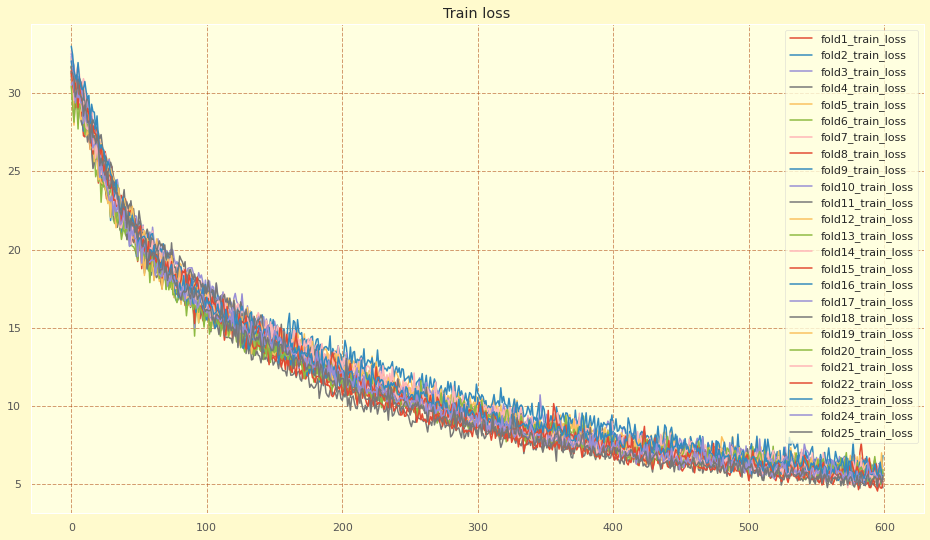

In [53]:
for i in stats.filter(like='train', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Train loss')
plt.legend()  

# Valid RMSE

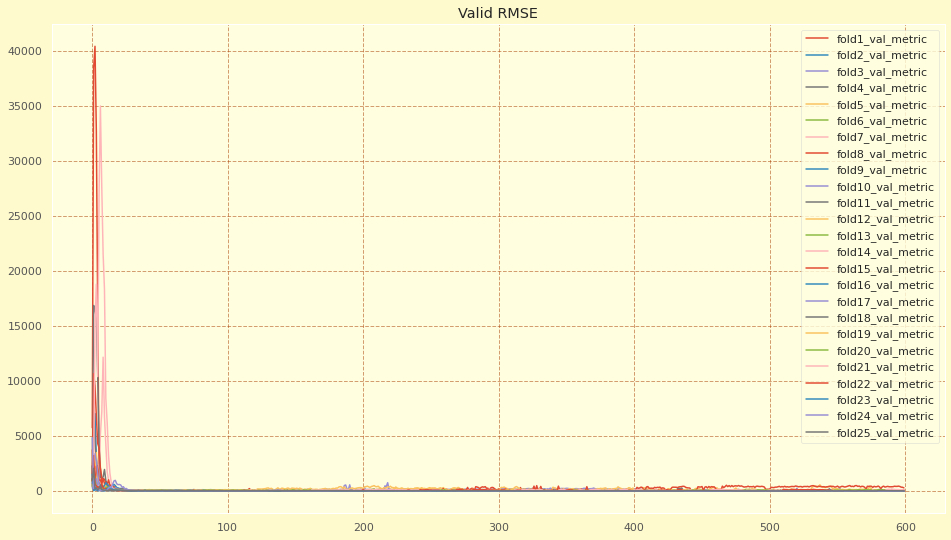

In [54]:
for i in stats.filter(like='val', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Valid RMSE')
plt.legend()

# Feature Importances

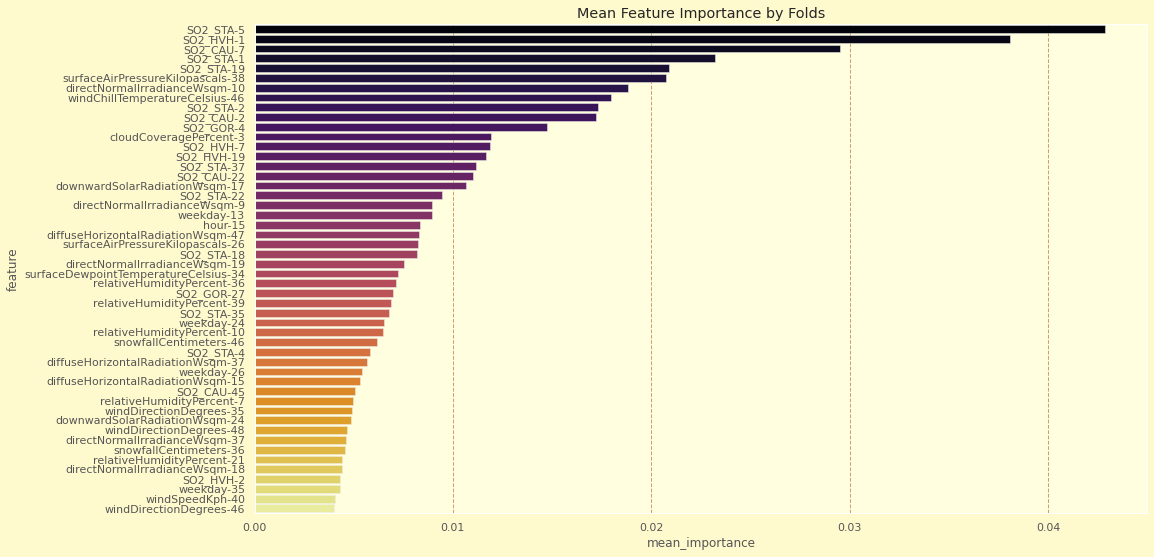

In [55]:
feature_importances['mean_importance']=feature_importances[['importance_fold0+1','importance_fold1+1']].mean(axis=1)
feature_importances.sort_values(by='mean_importance', ascending=False, inplace=True)
sns.barplot(y=feature_importances['feature'][:50],x=feature_importances['mean_importance'][:50], palette='inferno')
plt.title('Mean Feature Importance by Folds')
plt.show()

# Masks

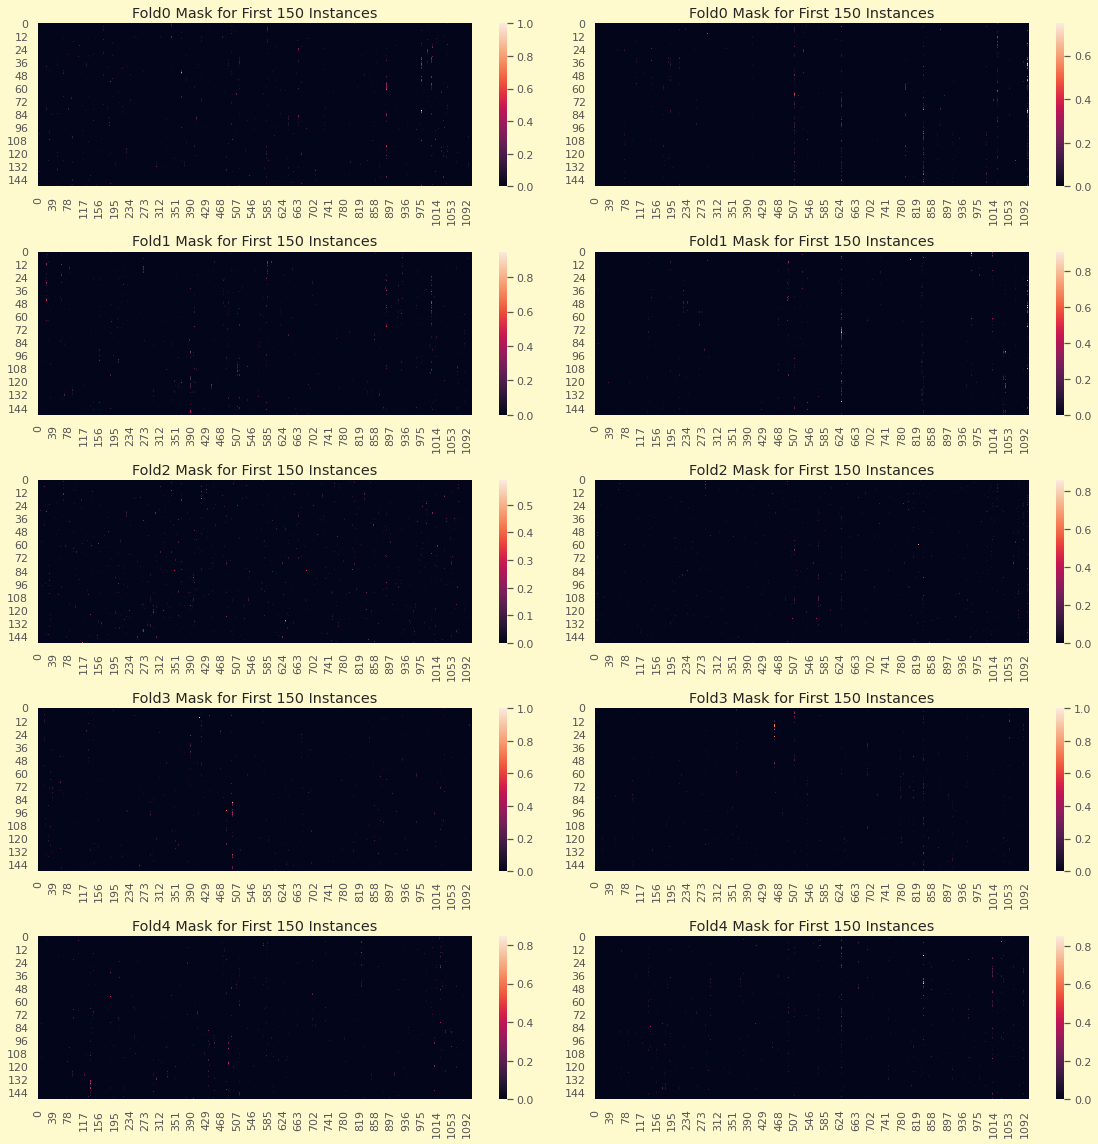

In [56]:
fig, axs = plt.subplots(5, 2, figsize=(16,16))
axs = axs.flatten()

k=-1    
for i, (mask, j) in enumerate(zip(masks_, axs)):
    sns.heatmap(mask[:150], ax=j)
    if i%2 == 0:
        k+=1
    j.set_title((f"Fold{k} Mask for First 150 Instances"))
plt.tight_layout()

# Explain Matrices

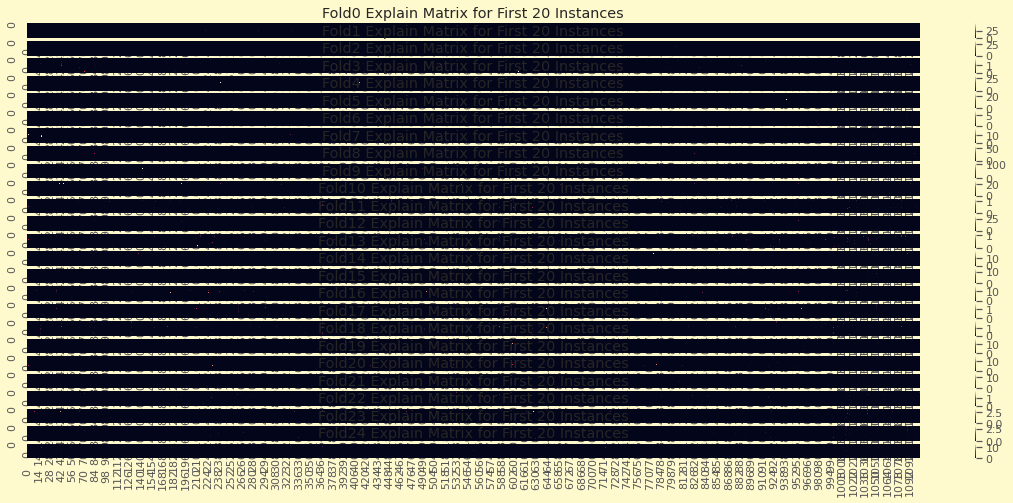

In [57]:
fig, axs = plt.subplots(len(explain_matrices), 1, figsize=(20,8))
for i,matrix in enumerate(explain_matrices):
    axs[i].set_title(f'Fold{i} Explain Matrix for First 20 Instances')
    sns.heatmap(matrix[:20], ax=axs[i])
plt.tight_layout() 

# Submission

In [58]:
submission[target_cols] = predictions_tabnet
submission.to_csv(f'submission_tabnet_version{VERSION}.csv', index=False)

In [59]:
submission

,ID,SO2_MAS+0,SO2_MAS+1,SO2_MAS+2,SO2_MAS+3,SO2_MAS+4,SO2_MAS+5,SO2_MAS+6,SO2_MAS+7,SO2_MAS+8,SO2_MAS+9,SO2_MAS+10,SO2_MAS+11
0,1,2.281346,2.382890,2.252548,1.820440,1.851537,1.777148,1.368658,1.266924,1.038418,0.953962,0.949955,1.016747
1,2,0.454011,0.394591,0.228327,0.290419,0.332973,0.448310,0.373774,0.434314,0.471337,0.639108,0.626343,0.608409
2,3,0.835672,0.685124,0.995308,1.298910,1.308919,1.204005,1.323982,1.392201,1.567897,2.100635,2.284545,2.165190
3,4,0.748204,0.687226,0.727028,0.602251,0.757222,0.788807,0.498023,0.491317,0.519655,0.514550,0.485260,0.551102
4,5,0.564420,0.426935,0.235085,0.123076,0.166257,0.417419,0.402338,0.491578,0.532411,0.512436,0.447923,0.496923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,164,0.612542,0.504841,0.466794,0.370338,0.449399,0.545634,0.426212,0.423628,0.399966,0.393574,0.402149,0.423477
164,165,0.777370,0.651772,0.576185,0.578446,0.657655,0.755552,0.399986,0.429413,0.547293,0.550465,0.470749,0.482319
165,166,0.514693,0.448400,0.433182,0.355326,0.455155,0.492757,0.227425,0.288741,0.441421,0.466650,0.407047,0.415597
166,167,1.074434,0.888703,0.701455,0.721768,0.732148,0.874228,0.843963,0.980501,1.276983,1.629990,1.613735,1.666654
